In [ ]:

import tensorflow as tf
from tensorflow.keras import layers, models, Input
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_absolute_error
import os
import yfinance as yf
import pickle
from google.colab import drive

In [ ]:
# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Load Data from your specific path
file_path = '/content/drive/MyDrive/CryptoData/BTC-USD.csv'
print(f"📂 Loading data from: {file_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 Loading data from: /content/drive/MyDrive/CryptoData/BTC-USD.csv


In [ ]:
BASE_DIR = '/content/drive/MyDrive/TimeGAN_Project_1'
CHECKPOINT_DIR = os.path.join(BASE_DIR, 'checkpoints')
MODEL_DIR = os.path.join(BASE_DIR, 'saved_models')
LOG_DIR = os.path.join(BASE_DIR, 'logs')
DATA_DIR = os.path.join(BASE_DIR, 'data')

In [ ]:
for path in [CHECKPOINT_DIR, MODEL_DIR, LOG_DIR, DATA_DIR]:
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
df = pd.read_csv(file_path)
print(df)

           Price               Close                High                Low  \
0         Ticker             BTC-USD             BTC-USD            BTC-USD   
1           Date                 NaN                 NaN                NaN   
2     2014-09-17   457.3340148925781  468.17401123046875  452.4219970703125   
3     2014-09-18  424.44000244140625   456.8599853515625    413.10400390625   
4     2014-09-19   394.7959899902344   427.8349914550781  384.5320129394531   
...          ...                 ...                 ...                ...   
3390  2023-12-27      43442.85546875      43683.16015625     42167.58203125   
3391  2023-12-28      42627.85546875         43804.78125     42318.55078125   
3392  2023-12-29      42099.40234375      43124.32421875         41424.0625   
3393  2023-12-30      42156.90234375           42584.125      41556.2265625   
3394  2023-12-31          42265.1875          42860.9375     41998.25390625   

                   Open       Volume  
0           

In [ ]:
import os

In [ ]:
import pandas as pd

# Reload data correctly by skipping the first two header rows.
# This ensures that numerical columns are parsed as numbers and
# the actual headers (Date, Close, High, etc.) are correctly identified.
# file_path is already defined from previous steps: '/content/drive/MyDrive/CryptoData/BTC-USD.csv'
df = pd.read_csv(file_path, skiprows=2)

# Rename the first column, which now contains the actual date values, from 'Price' to 'Date'
# Also rename the other 'Unnamed' columns to their correct headers based on the CSV structure
df = df.rename(columns={
    'Price': 'Date',
    'Unnamed: 1': 'Close',
    'Unnamed: 2': 'High',
    'Unnamed: 3': 'Low',
    'Unnamed: 4': 'Open',
    'Unnamed: 5': 'Volume'
})

# Display the first few rows and data types to confirm the fix
print("DataFrame after reloading with skiprows and renaming 'Price' to 'Date':")
print(df.head())
print("\nDataFrame Info (check dtypes):")
df.info()

DataFrame after reloading with skiprows and renaming 'Price' to 'Date':
         Date       Close        High         Low        Open    Volume
0  2014-09-17  457.334015  468.174011  452.421997  465.864014  21056800
1  2014-09-18  424.440002  456.859985  413.104004  456.859985  34483200
2  2014-09-19  394.795990  427.834991  384.532013  424.102997  37919700
3  2014-09-20  408.903992  423.295990  389.882996  394.673004  36863600
4  2014-09-21  398.821014  412.425995  393.181000  408.084991  26580100

DataFrame Info (check dtypes):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3393 entries, 0 to 3392
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3393 non-null   object 
 1   Close   3393 non-null   float64
 2   High    3393 non-null   float64
 3   Low     3393 non-null   float64
 4   Open    3393 non-null   float64
 5   Volume  3393 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 159.2+ K

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Calculate Log Returns (Stabilizes the data for AI)
# We check for 'Adj Close' or 'Close' to be safe
price_col = 'Adj Close' if 'Adj Close' in df.columns else 'Close'
df['Log_Returns'] = np.log(df[price_col] / df[price_col].shift(1))
df.dropna(inplace=True)

# Select Features for the Model
# (Open, High, Low, Close, Volume, Returns)
feature_cols = ['Open', 'High', 'Low', price_col, 'Volume', 'Log_Returns']
data_values = df[feature_cols].values

# 4. Scale Data (0 to 1)
# Neural Networks fail if data isn't scaled
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_values)
print(data_scaled)
print(f"✅ Data Loaded & Scaled! Shape: {data_scaled.shape}")

[[4.15542811e-03 3.57446064e-03 3.64887469e-03 3.65546321e-03
  8.14009147e-05 5.65466864e-01]
 [3.66922343e-03 3.15121938e-03 3.21734241e-03 3.21556748e-03
  9.11925723e-05 5.68716622e-01]
 [3.23240062e-03 3.08503185e-03 3.29816008e-03 3.42492004e-03
  8.81834148e-05 7.24566275e-01]
 ...
 [6.29894022e-01 6.25749651e-01 6.23051024e-01 6.22081799e-01
  7.40652962e-02 6.55586528e-01]
 [6.22132873e-01 6.17872488e-01 6.25047141e-01 6.22935057e-01
  4.56118045e-02 6.75647817e-01]
 [6.23028542e-01 6.21908957e-01 6.31723227e-01 6.24541931e-01
  4.67047230e-02 6.77387974e-01]]
✅ Data Loaded & Scaled! Shape: (3392, 6)


In [ ]:
# Configuration
SEQ_LEN = 24  # Look at the past 24 days to predict the future

# Create Rolling Windows
X = []
for i in range(len(data_scaled) - SEQ_LEN):
    X.append(data_scaled[i : i + SEQ_LEN])
X_train = np.array(X)

print(f"✅ Data processed for TimeGAN: {X_train.shape}")
# Expected output: (Samples, 24, 6)

✅ Data processed for TimeGAN: (3368, 24, 6)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
SEQ_LEN = 24
N_FEATURES = 6
HIDDEN_DIM = 64
BATCH_SIZE = 128
GAMMA = 2.0
Z_DIM = 32

In [ ]:
def make_net(input_shape, output_dim, activation='tanh', name="Net"):
    model = models.Sequential(name=name)
    model.add(layers.Input(shape=input_shape))
    model.add(layers.GRU(HIDDEN_DIM, return_sequences=True))
    model.add(layers.GRU(HIDDEN_DIM, return_sequences=True))
    model.add(layers.Dense(output_dim, activation=activation))
    return model

In [ ]:
embedder = make_net((SEQ_LEN, N_FEATURES), HIDDEN_DIM, 'linear', "Embedder")
recovery = make_net((SEQ_LEN, HIDDEN_DIM), N_FEATURES, 'sigmoid', "Recovery")
generator = make_net((SEQ_LEN, Z_DIM), HIDDEN_DIM, 'tanh', "Generator")
supervisor = make_net((SEQ_LEN, HIDDEN_DIM), HIDDEN_DIM, 'linear', "Supervisor")
discriminator = make_net((SEQ_LEN, HIDDEN_DIM), 1, 'linear', "Discriminator")


In [ ]:
e_opt = tf.keras.optimizers.Adam(learning_rate=0.001)
d_opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
g_opt = tf.keras.optimizers.Adam(learning_rate=0.002)
sup_opt = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
e_opt.build(embedder.trainable_variables + recovery.trainable_variables)

# Build sup_opt (Used in Phase 2 & 3)
sup_opt.build(generator.trainable_variables + supervisor.trainable_variables)

# Build g_opt (Used ONLY in Phase 3 - This was causing your crash!)
g_opt.build(generator.trainable_variables + supervisor.trainable_variables)

# Build d_opt (Used ONLY in Phase 3)
d_opt.build(discriminator.trainable_variables)

In [ ]:
ckpt = tf.train.Checkpoint(embedder=embedder, recovery=recovery,
                           generator=generator, supervisor=supervisor,
                           discriminator=discriminator,
                           e_opt=e_opt, d_opt=d_opt, g_opt=g_opt, sup_opt=sup_opt)

manager = tf.train.CheckpointManager(ckpt, CHECKPOINT_DIR, max_to_keep=3)


In [ ]:
if manager.latest_checkpoint:
    ckpt.restore(manager.latest_checkpoint)
    print(f"✅ RESTORED model from {manager.latest_checkpoint}")
else:
    print("🆕 Initializing new model.")


✅ RESTORED model from /content/drive/MyDrive/TimeGAN_Project_1/checkpoints/ckpt-28


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(X_train.astype(np.float32)).shuffle(1000).batch(BATCH_SIZE)

In [ ]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [ ]:
@tf.function
def grad_penalty(real, fake):
    batch = tf.shape(real)[0]
    alpha = tf.random.uniform([batch, 1, 1], 0.0, 1.0)

    interpolated = alpha * real + (1 - alpha) * fake
    with tf.GradientTape() as t:
        t.watch(interpolated)
        pred = discriminator(interpolated)

    grads = t.gradient(pred, interpolated)
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]) + 1e-6)

    return tf.reduce_mean((norm - 1.0) ** 2)


In [ ]:
def train_autoencoder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        x_tilde = recovery(h)
        loss = 10 * tf.keras.losses.MeanSquaredError()(x, x_tilde)
    vars = embedder.trainable_variables + recovery.trainable_variables
    grads = tape.gradient(loss, vars)
    e_opt.apply_gradients(zip(grads, vars))
    return loss

In [ ]:
def train_supervisor(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        loss = tf.keras.losses.MeanSquaredError()(h[:, 1:, :], h_hat_supervised[:, :-1, :])
    vars = generator.trainable_variables + supervisor.trainable_variables
    grads = tape.gradient(loss, vars)
    sup_opt.apply_gradients(zip(grads, vars))
    return loss

In [ ]:
@tf.function
def train_generator(x, z):
    with tf.GradientTape() as tape:
        # ---- 1) GENERATOR FORWARD ----
        e_hat = generator(z)                # latent
        h_hat = supervisor(e_hat)           # temporal latent
        x_hat = recovery(h_hat)             # reconstructed features

        # ---- 2) ADVERSARIAL LOSS ----
        y_fake = discriminator(h_hat)
        g_u = bce(tf.ones_like(y_fake), y_fake)  # fool discriminator

        # ---- 3) SUPERVISED TEMPORAL LOSS ----
        h_real = embedder(x)
        g_s = tf.reduce_mean(tf.square(h_real[:, 1:, :] - h_hat[:, :-1, :]))

        # ---- 4) MOMENTS LOSS ----
        m_real = tf.nn.moments(x, [0])
        m_fake = tf.nn.moments(x_hat, [0])

        g_v = tf.reduce_mean(tf.abs(m_real[0] - m_fake[0])) + \
              tf.reduce_mean(tf.abs(tf.sqrt(m_real[1]+1e-6) - tf.sqrt(m_fake[1]+1e-6)))

        # ---- 5) LATENT SPREAD REGULARIZER ----
        noise_reg = tf.reduce_mean(tf.square(
            tf.random.normal(tf.shape(e_hat)) * 0.01
        ))

        # ---- TOTAL GENERATOR LOSS ----
        g_loss = (
            1 * g_u           # weak early adversarial
          + 5.0 * g_s          # strong temporal dynamics
          + 10.0 * g_v          # strong distribution matching
          + 0.1 * noise_reg     # diversity
        )

    vars = generator.trainable_variables + supervisor.trainable_variables
    grads = tape.gradient(g_loss, vars)
    g_opt.apply_gradients(zip(grads, vars))

    return g_loss, g_u, g_s, g_v


In [ ]:
def train_embedder(x):
    with tf.GradientTape() as tape:
        # Reconstruction Loss
        h = embedder(x)
        x_tilde = recovery(h)
        e_loss_t0 = 10 * tf.keras.losses.MeanSquaredError()(x, x_tilde)

        # Supervised Guidance
        h_hat_supervised = supervisor(h)
        g_loss_s = tf.keras.losses.MeanSquaredError()(h[:, 1:, :], h_hat_supervised[:, :-1, :])

        e_loss = e_loss_t0 + 0.1 * tf.sqrt(g_loss_s)

    vars = embedder.trainable_variables + recovery.trainable_variables
    grads = tape.gradient(e_loss, vars)
    e_opt.apply_gradients(zip(grads, vars))
    return e_loss

In [ ]:
@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        # Real latent embeddings
        h_real = embedder(x)

        # Fake latent embeddings
        h_fake = supervisor(generator(z))

        # Discriminator predictions
        y_real = discriminator(h_real)
        y_fake = discriminator(h_fake)

        # Adversarial loss
        adv_loss = (
            bce(tf.ones_like(y_real), y_real) +
            bce(tf.zeros_like(y_fake), y_fake)
        )



        # Final discriminator loss
        d_loss = adv_loss

    vars = discriminator.trainable_variables
    grads = tape.gradient(d_loss, vars)
    d_opt.apply_gradients(zip(grads, vars))

    return d_loss


In [ ]:
history_path = os.path.join(LOG_DIR, 'loss_history.pkl')

if os.path.exists(history_path):
    with open(history_path, 'rb') as f:
        loss_history = pickle.load(f)
    print("🔄 Loaded existing loss history!")
else:
    loss_history = {'ae': [], 'sup': [], 'd': [], 'g': [], 'e': []}
    print("🆕 Starting new loss history.")


🔄 Loaded existing loss history!


In [ ]:
print("⏳ Phase 1: Training Autoencoder...")
for epoch in range(100):
    for x in dataset:
        loss = train_autoencoder(x)

    # Add loss to history
    loss_history['ae'].append(loss.numpy())

    # Every 20 epochs: print + save checkpoint
    if epoch % 20 == 0:
        print(f"Epoch {epoch} | AE Loss: {loss:.4f}")
        manager.save()

    # ✅ Save the MAIN history file every epoch (recommended)
    with open(history_path, 'wb') as f:
        pickle.dump(loss_history, f)

    # Also save a backup every 50 epochs
    if epoch % 50 == 0 and epoch > 0:
        backup_path = os.path.join(LOG_DIR, f'loss_history_backup_epoch_{epoch}.pkl')
        with open(backup_path, 'wb') as f:
            pickle.dump(loss_history, f)

⏳ Phase 1: Training Autoencoder...
Epoch 0 | AE Loss: 0.7038
Epoch 20 | AE Loss: 0.0106
Epoch 40 | AE Loss: 0.0069
Epoch 60 | AE Loss: 0.0034
Epoch 80 | AE Loss: 0.0023


In [ ]:
print("⏳ Phase 2: Training Supervisor...")
for epoch in range(100):
    for x in dataset:
        loss = train_supervisor(x)
    loss_history['sup'].append(loss.numpy())
    if epoch % 20 == 0:
        print(f"Epoch {epoch} | Sup Loss: {loss:.4f}")
        manager.save()
    with open(history_path, 'wb') as f:
        pickle.dump(loss_history, f)
    if epoch % 50 == 0:
        backup_path = os.path.join(LOG_DIR, f'loss_history_backup_epoch_{epoch}.pkl')
        with open(backup_path, 'wb') as f:
            pickle.dump(loss_history, f)

⏳ Phase 2: Training Supervisor...


/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['Generator/gru_24/gru_cell/kernel', 'Generator/gru_24/gru_cell/recurrent_kernel', 'Generator/gru_24/gru_cell/bias', 'Generator/gru_25/gru_cell/kernel', 'Generator/gru_25/gru_cell/recurrent_kernel', 'Generator/gru_25/gru_cell/bias', 'Generator/dense_12/kernel', 'Generator/dense_12/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch 0 | Sup Loss: 0.0387
Epoch 20 | Sup Loss: 0.0012
Epoch 40 | Sup Loss: 0.0012
Epoch 60 | Sup Loss: 0.0010
Epoch 80 | Sup Loss: 0.0008


In [ ]:
print("⏳ Phase 3: Joint Training (The Main Loop)...")
# Recommend: 1000 to 5000 epochs for good results. Start with 1000.
JOINT_EPOCHS = 100

for epoch in range(JOINT_EPOCHS):
    for x in dataset:
        z = tf.random.normal((x.shape[0], SEQ_LEN, Z_DIM))
        for _ in range(5):
          g_loss, g_u, g_s, g_v = train_generator(x, z)
        e_loss = train_embedder(x)

        d_loss = train_discriminator(x, z)


    # Log losses
    loss_history['d'].append(d_loss.numpy())
    loss_history['g'].append(g_loss.numpy())
    loss_history['e'].append(e_loss.numpy())

    if epoch % 20 == 0:
        print(f"Epoch {epoch} | D: {d_loss:.4f} | G: {g_loss:.4f} | E: {e_loss:.4f}")
        manager.save()
    with open(history_path, 'wb') as f:
        pickle.dump(loss_history, f)
    if epoch % 50 == 0:
        backup_path = os.path.join(LOG_DIR, f'loss_history_backup_epoch_{epoch}.pkl')
        with open(backup_path, 'wb') as f:
            pickle.dump(loss_history, f)

print("✅ Training Complete!")

⏳ Phase 3: Joint Training (The Main Loop)...
Epoch 0 | D: 1.6552 | G: 0.7893 | E: 0.0036
Epoch 20 | D: 1.2523 | G: 0.8130 | E: 0.0049
Epoch 40 | D: 1.2222 | G: 1.0297 | E: 0.0035
Epoch 60 | D: 1.0074 | G: 1.1980 | E: 0.0046
Epoch 80 | D: 1.7506 | G: 0.7442 | E: 0.0040
✅ Training Complete!


# **SAVE BELOW CODE FOR FUTURE**

In [ ]:

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
print("🚀 Generating Synthetic Data...")
Z_mb = tf.random.normal(shape=(len(X_train), SEQ_LEN, Z_DIM))


# Run Generator -> Supervisor -> Recovery
E_hat = generator(Z_mb)           # Noise -> Latent
H_hat = supervisor(E_hat)         # Latent -> Temporal Latent
synthetic_data = recovery(H_hat)  # Temporal Latent -> Real Space (Features)

synthetic_data = synthetic_data.numpy()
print(f"✅ Generated Data Shape: {synthetic_data.shape}")

🚀 Generating Synthetic Data...
✅ Generated Data Shape: (3368, 24, 6)


In [ ]:
X_train.shape        # (N, T, F)
 # (N_s, T, F)


(3368, 24, 6)

In [ ]:
synthetic_data.shape

(3368, 24, 6)

**(a) Shapes & basic stats**

In [ ]:
print("Real:", X_train.shape, "Synthetic:", synthetic_data.shape)

print("Real mean/std:", X_train.mean(), X_train.std())
print("Syn  mean/std:", synthetic_data.mean(), synthetic_data.std())


Real: (3368, 24, 6) Synthetic: (3368, 24, 6)
Real mean/std: 0.2622681192605236 0.2774055243644095
Syn  mean/std: 0.3523379 0.2866582


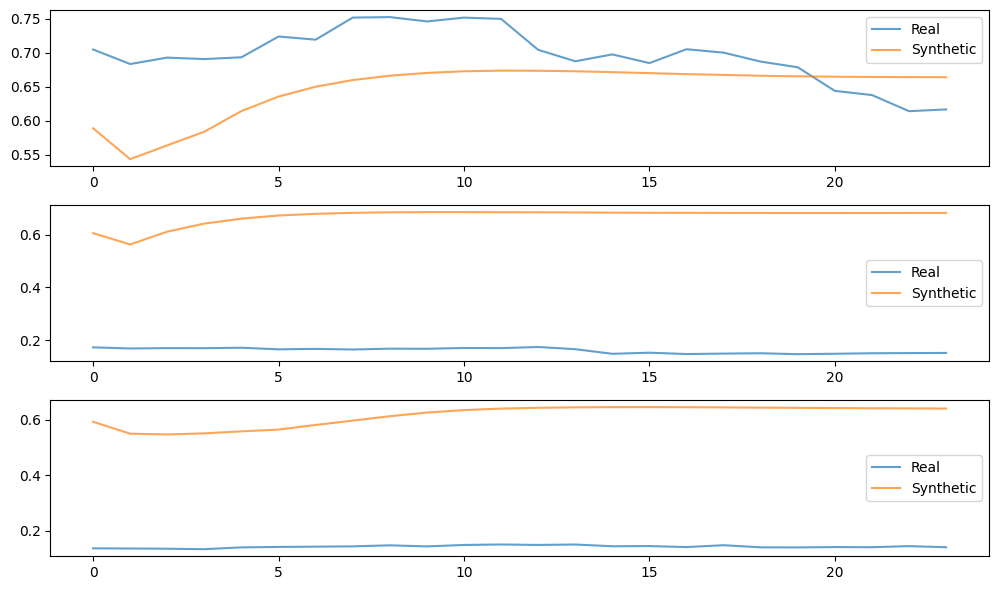

In [ ]:
idx = np.random.randint(0, len(X_train), size=3)

fig, axes = plt.subplots(len(idx), 1, figsize=(10, 6))
for i, ax in zip(idx, axes):
    ax.plot(X_train[i,:,0], alpha=0.7, label="Real")
    ax.plot(synthetic_data[i,:,0], alpha=0.7, label="Synthetic")
    ax.legend()
plt.tight_layout()
plt.show()


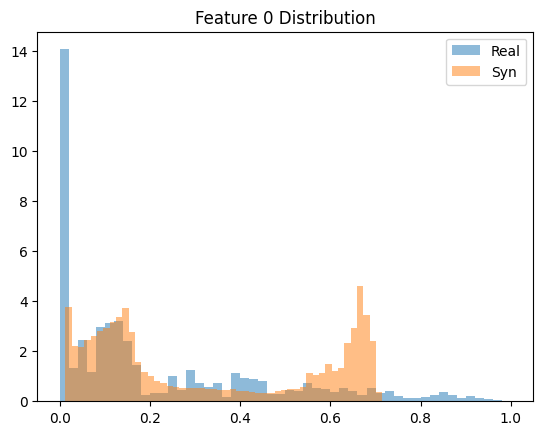

In [ ]:
real_feat0 = X_train[:,:,0].flatten()
syn_feat0  = synthetic_data[:,:,0].flatten()

plt.hist(real_feat0, bins=50, density=True, alpha=0.5, label="Real")
plt.hist(syn_feat0,  bins=50, density=True, alpha=0.5, label="Syn")
plt.legend(); plt.title("Feature 0 Distribution"); plt.show()


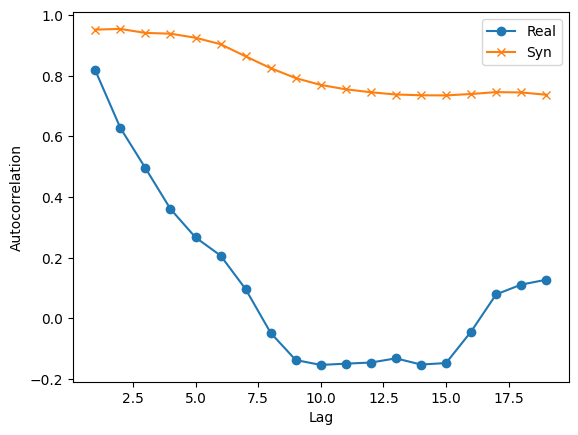

In [ ]:
def autocorr(x, lag):
    return np.corrcoef(x[:-lag], x[lag:])[0,1]

lags = range(1, 20)
real_ac = []
syn_ac  = []

for l in lags:
    r_vals = []
    s_vals = []
    for i in range(200):  # sample 200 sequences
        r_vals.append(autocorr(X_train[i,:,0], l))
        s_vals.append(autocorr(synthetic_data[i,:,0], l))
    real_ac.append(np.mean(r_vals))
    syn_ac.append(np.mean(s_vals))

plt.plot(lags, real_ac, marker='o', label="Real")
plt.plot(lags, syn_ac, marker='x', label="Syn")
plt.xlabel("Lag"); plt.ylabel("Autocorrelation"); plt.legend()
plt.show()


In [ ]:
from tensorflow.keras import layers, models
import numpy as np

n_real = len(X_train)
n_syn  = len(synthetic_data)

n = min(n_real, n_syn)
Xr = X_train[:n]
Xs = synthetic_data[:n]

X = np.concatenate([Xr, Xs], axis=0)
y = np.concatenate([np.ones(n), np.zeros(n)], axis=0)  # 1=real, 0=syn

idx = np.random.permutation(len(X))
X, y = X[idx], y[idx]

split = int(0.8 * len(X))
X_train_clf, X_test_clf = X[:split], X[split:]
y_train_clf, y_test_clf = y[:split], y[split:]

model = models.Sequential([
    layers.Input(shape=X_train_clf.shape[1:]),   # (T, F)
    layers.LSTM(64),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(X_train_clf, y_train_clf, epochs=10, batch_size=64, verbose=0)

loss, acc = model.evaluate(X_test_clf, y_test_clf, verbose=0)
print("Discriminative accuracy:", acc)
print("Discriminative score (|acc - 0.5|):", abs(acc - 0.5))


Discriminative accuracy: 0.9955489635467529
Discriminative score (|acc - 0.5|): 0.49554896354675293


In [ ]:
# assume predicting last step from previous T-1
X_real_in  = X_train[:,:-1,:]
y_real_out = X_train[:,-1,:]

X_syn_in   = synthetic_data[:,:-1,:]
y_syn_out  = synthetic_data[:,-1,:]

split = int(0.8 * len(X_train))
Xr_tr, Xr_te = X_real_in[:split], X_real_in[split:]
yr_tr, yr_te = y_real_out[:split], y_real_out[split:]

Xs_tr, Xs_te = X_syn_in[:split], X_syn_in[split:]
ys_tr, ys_te = y_syn_out[:split], y_syn_out[split:]

def make_forecaster():
    m = models.Sequential([
        layers.Input(shape=Xr_tr.shape[1:]),
        layers.LSTM(64),
        layers.Dense(y_real_out.shape[-1])
    ])
    m.compile(optimizer="adam", loss="mse")
    return m

# Train on real → test on real
m_real = make_forecaster()
m_real.fit(Xr_tr, yr_tr, epochs=10, batch_size=64, verbose=0)
real_rmse = np.sqrt(m_real.evaluate(Xr_te, yr_te, verbose=0))

# Train on synthetic → test on real
m_syn = make_forecaster()
m_syn.fit(Xs_tr, ys_tr, epochs=10, batch_size=64, verbose=0)
syn_rmse = np.sqrt(m_syn.evaluate(Xr_te, yr_te, verbose=0))

print("RMSE (Train Real → Test Real):", real_rmse)
print("RMSE (Train Syn  → Test Real):", syn_rmse)
print("Predictive score:", syn_rmse / real_rmse)


RMSE (Train Real → Test Real): 0.027147328402141742
RMSE (Train Syn  → Test Real): 0.03306124505807674
Predictive score: 1.217845254174935


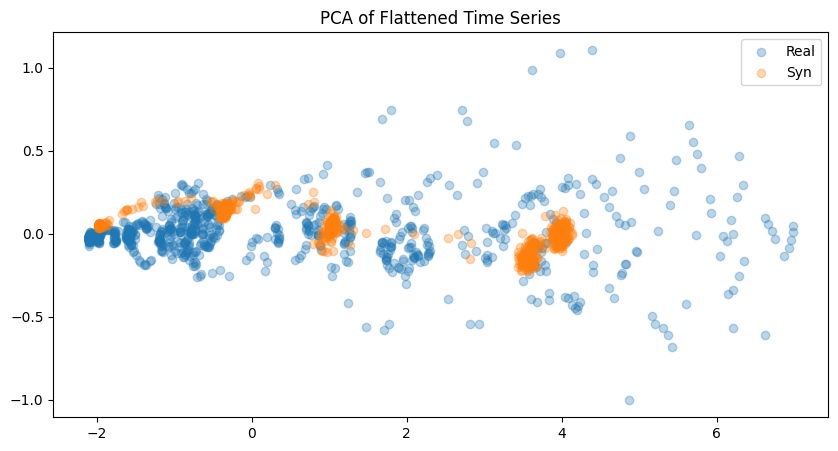

In [ ]:
n = 1000
idx = np.random.choice(len(X_train), n, replace=False)

real_flat = X_train[idx].reshape(n, -1)
syn_flat  = synthetic_data[:n].reshape(n, -1)

pca = PCA(n_components=2)
pca_real = pca.fit_transform(real_flat)
pca_syn  = pca.transform(syn_flat)

plt.figure(figsize=(10,5))
plt.scatter(pca_real[:,0], pca_real[:,1], alpha=0.3, label="Real")
plt.scatter(pca_syn[:,0],  pca_syn[:,1],  alpha=0.3, label="Syn")
plt.legend(); plt.title("PCA of Flattened Time Series"); plt.show()


📊 Running pca visualization...


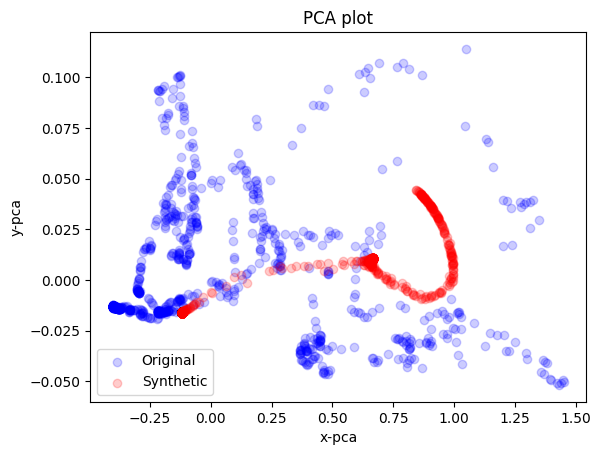

📊 Running tsne visualization...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.003s...
[t-SNE] Computed neighbors for 2000 samples in 0.046s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.000031


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.635231
[t-SNE] KL divergence after 300 iterations: 0.830047


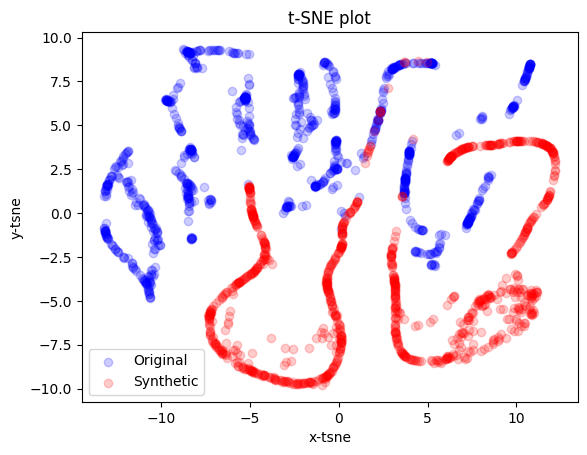

📈 Plotting Sample Sequences (Real vs Synthetic)...


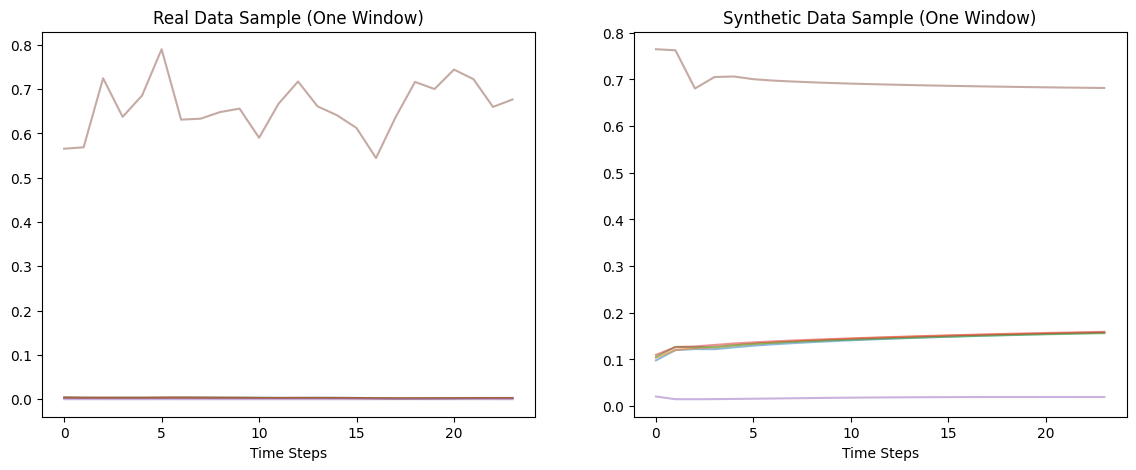

In [ ]:
# ==========================================
# 6. GENERATION & VISUALIZATION
# ==========================================


# 1. Generate Synthetic Data
# We generate the same number of sequences as we have in the real training set
# Input to generator is Random Noise (Z)


# 2. Rescale Data (Optional but recommended for interpretation)
# Inverse transform to get back to original scale (e.g., real prices)
# Note: We must reshape to 2D for scaler, then back to 3D
# generated_data_2d = scaler.inverse_transform(synthetic_data.reshape(-1, N_FEATURES))
# generated_data_3d = generated_data_2d.reshape(synthetic_data.shape)

# 3. Visualization Function
def visualization(ori_data, generated_data, analysis):
    """Using PCA or tSNE for generated and original data visualization.

    Args:
      - ori_data: original data
      - generated_data: generated synthetic data
      - analysis: tsne or pca
    """
    # Analysis starting point
    print(f"📊 Running {analysis} visualization...")

    # Data preprocessing
    no, seq_len, dim = ori_data.shape

    # Randomly sample a subset for visualization to speed it up
    idx = np.random.permutation(no)[:1000]

    # Flatten the data (Sample, Seq_Len * Features) or Average over time
    # Here we take the Mean over time to visualize the "Average Behavior" of each sequence
    ori_data_flat = np.mean(ori_data[idx], axis=1)
    generated_data_flat = np.mean(generated_data[idx], axis=1)

    if analysis == 'pca':
        # PCA
        pca = PCA(n_components = 2)
        pca.fit(ori_data_flat)
        pca_results = pca.transform(ori_data_flat)
        pca_hat_results = pca.transform(generated_data_flat)

        # Plotting
        f, ax = plt.subplots(1)
        plt.scatter(pca_results[:,0], pca_results[:,1],
                    c = 'blue', alpha = 0.2, label = "Original")
        plt.scatter(pca_hat_results[:,0], pca_hat_results[:,1],
                    c = 'red', alpha = 0.2, label = "Synthetic")

        ax.legend()
        plt.title('PCA plot')
        plt.xlabel('x-pca')
        plt.ylabel('y-pca')
        plt.show()

    elif analysis == 'tsne':
        # t-SNE
        prep_data = np.concatenate((ori_data_flat, generated_data_flat), axis = 0)

        # TSNE often fails with perplexity > n_samples, so we set it safely
        tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)
        tsne_results = tsne.fit_transform(prep_data)

        # Plotting
        f, ax = plt.subplots(1)
        plt.scatter(tsne_results[:len(idx),0], tsne_results[:len(idx),1],
                    c = 'blue', alpha = 0.2, label = "Original")
        plt.scatter(tsne_results[len(idx):,0], tsne_results[len(idx):,1],
                    c = 'red', alpha = 0.2, label = "Synthetic")

        ax.legend()
        plt.title('t-SNE plot')
        plt.xlabel('x-tsne')
        plt.ylabel('y-tsne')
        plt.show()

# 4. Run Visualizations
visualization(X_train, synthetic_data, 'pca')
visualization(X_train, synthetic_data, 'tsne')

# 5. Plot Individual Time Series (Visual Inspection)
print("📈 Plotting Sample Sequences (Real vs Synthetic)...")
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot Real
ax[0].plot(X_train[0, :, :], alpha=0.5)
ax[0].set_title('Real Data Sample (One Window)')
ax[0].set_xlabel('Time Steps')

# Plot Synthetic
ax[1].plot(synthetic_data[0, :, :], alpha=0.5)
ax[1].set_title('Synthetic Data Sample (One Window)')
ax[1].set_xlabel('Time Steps')

plt.show()